In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, Election, MarkovChain, proposals, updaters, constraints, accept, GeographicPartition
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from functools import partial
from gerrychain.metrics import polsby_popper
import os

In [24]:

PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd(), "..", "data", "processed")
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "utah", "UTAH_VTDs.shp")
EXPORT_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "utah")
ITERATIONS = 100
SAFE_SEAT_THRESHOLD = 0.66
MINORITY_POP_THRESHOLD = RACE_WINNER_THRESHOLD = 0.5
TOTAL_DISTRICTS = 4

In [25]:
UT_graph = Graph.from_file(NC_PATH, ignore_errors=True)

In [26]:
UT_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

<AxesSubplot: >

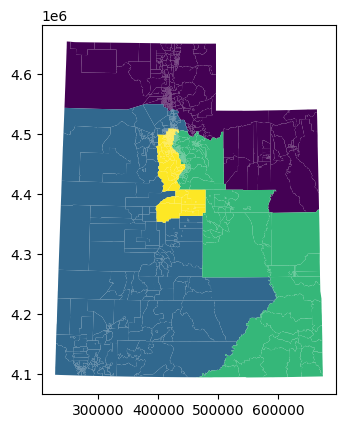

In [27]:
initial_partition = GeographicPartition(
    UT_graph,
    assignment="CD",
    updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": UT_election
    }
)
initial_partition.plot()

In [28]:
ideal_pop = sum(initial_partition["population"].values()) / len(initial_partition)
proposal = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop, epsilon=.02, node_repeats=2)
compactness = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [29]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        compactness,
        pop_constraint
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=ITERATIONS
)

In [30]:
i = 0
for partition in chain:
    if i == 1:
        break
    white = pd.Series(partition["white"]).astype(int)
    display(white)
    i += 1

1.0    571582
2.0    540741
3.0    580265
4.0    529279
dtype: int64

In [31]:
# Supress user warnings
import warnings
warnings.filterwarnings('ignore')

OPPORTUNITY_REP_COUNT = int(TOTAL_DISTRICTS * 0.25)
print(f"OPPORTUNITY_REP_COUNT: {OPPORTUNITY_REP_COUNT}")

# Calculate polsby popper score, republican and democratic split
polsby_popper_scores = pd.DataFrame()
dem_splits = pd.DataFrame()
rep_splits = pd.DataFrame()
black_pop = pd.DataFrame()
asian_pop = pd.DataFrame()
hisp_pop = pd.DataFrame()
white_pop = pd.DataFrame()
total_pop = pd.DataFrame()
equal_pop = pd.DataFrame()

unique_plans = {}


indexes = [1, 2, 3, 4]

for partition in chain:
    blk = pd.Series(partition["black"], index=indexes)
    asn = pd.Series(partition["asian"], index=indexes)
    hsp = pd.Series(partition["hisp"], index=indexes)
    wt = pd.Series(partition["white"], index=indexes)
    tot = pd.Series(partition["population"], index=indexes)
    
    dem = pd.Series(partition["CongressionalRace"].percents("Democratic"), index=indexes)
    rep = pd.Series(partition["CongressionalRace"].percents("Republican"), index=indexes)
    
    polsby_popper_scores = polsby_popper_scores.append(pd.Series(polsby_popper(partition), index=indexes), ignore_index=True)
    black_pop = black_pop.append(blk, ignore_index=True)
    asian_pop = asian_pop.append(asn, ignore_index=True)
    hisp_pop = hisp_pop.append(hsp, ignore_index=True)
    white_pop = white_pop.append(wt, ignore_index=True)
    total_pop = total_pop.append(tot, ignore_index=True)
    
    equal_pop = equal_pop.append(pd.Series(max(partition["population"].values()) - min(partition["population"].values())), ignore_index=True)

    dem_splits = dem_splits.append(dem, ignore_index=True)
    rep_splits = rep_splits.append(rep, ignore_index=True)

    minority_pop = blk + asn + hsp
    minority_pop_percentage = minority_pop / tot
    
    
    dem_seat_share_percentage = dem[dem > 0.5].count() / TOTAL_DISTRICTS
    dem_vote_share_percentage = dem.mean()

    # For a plan to be unique, it must meet any of the following criteria:
	# 1. > 80% Republican split
	# 2. > 80% Democratic split
	# 3. A district where the minority population is > 40% 
	# 4. Over 50 opporunity representatives within the partition
	# 5. Seat share and vote share are within 5% of each other

    if dem.max() > 0.9:
        unique_plans["democrat split > .90"] = partition
        
    if rep.max() > 0.9:
        unique_plans["republican split > .90"] = partition
        
    if minority_pop_percentage[minority_pop_percentage > 0.4].count().sum() >= OPPORTUNITY_REP_COUNT:
        unique_plans["high opportunity rep count"] = partition
        
    if abs(dem_seat_share_percentage - dem_vote_share_percentage) > 0.15:
        unique_plans["high vote seat share skew"] = partition
        
        
display(f"Number of unique plans: {len(unique_plans)}")

rep_safe_districts = rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
dem_safe_districts = dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count(axis=1)
minority_pop = black_pop + asian_pop + hisp_pop
opportunity_reps = minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()
dem_seat_share = dem_splits[dem_splits > RACE_WINNER_THRESHOLD].count(axis=1)
dem_seat_share_percentage = dem_seat_share / TOTAL_DISTRICTS

rep_seat_share = rep_splits[rep_splits > RACE_WINNER_THRESHOLD].count(axis=1)
rep_seat_share_percentage = rep_seat_share / TOTAL_DISTRICTS
equal_pop_measure = equal_pop.mean() / sum(initial_partition["population"].values())

OPPORTUNITY_REP_COUNT: 1


'Number of unique plans: 1'

# Equal population measure

In [32]:
equal_pop_measure = equal_pop_measure.values[0]

# Polsby Popper Scores

In [33]:
polsby_popper_scores

,1,2,3,4
0,0.189414,0.164715,0.255927,0.178456
1,0.189414,0.185912,0.255927,0.222699
2,0.189414,0.192781,0.255927,0.181994
3,0.189414,0.171531,0.255927,0.150270
4,0.305954,0.171531,0.255927,0.190535
...,...,...,...,...
95,0.232499,0.107321,0.308358,0.272022
96,0.292224,0.107321,0.258618,0.272022
97,0.292224,0.107321,0.217103,0.201761
98,0.292224,0.220925,0.132238,0.201761


# Republican Party Splits

In [34]:
rep_splits.mean()

1    0.708206
2    0.694552
3    0.727530
4    0.731391
dtype: float64

# Republican Safe Districts

In [35]:
rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count()

1    83
2    62
3    78
4    77
dtype: int64

# Democrat Party Splits

In [36]:
dem_splits.mean()

1    0.291794
2    0.305448
3    0.272470
4    0.268609
dtype: float64

# Democrat Safe Districts

In [37]:
dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count()

1    0
2    0
3    0
4    0
dtype: int64

# Majority-minority districts

In [38]:
minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()

1    0
2    0
3    0
4    0
dtype: int64

# Vote Share Seat Share
## Democrat

In [39]:
dem_vote_share_percentage

0.2851372802033852

# Box & Whisker for Population

In [40]:
black_pop_box_data = pd.DataFrame(black_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
asian_pop_box_data = pd.DataFrame(asian_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
hispanic_pop_box_data = pd.DataFrame(hisp_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
white_pop_box_data = pd.DataFrame(white_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
total_pop_box_data = pd.DataFrame(total_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])

# Export Time

## Unique Plan District

In [41]:
for reason in unique_plans:
    plan = unique_plans[reason]
    gdf = gpd.GeoDataFrame({"assignment": plan.assignment.to_series()}, geometry=plan.graph.geometry)
    district_shapes = gdf.dissolve(by='assignment', aggfunc='sum') # Combine the precincts to form districts
    district_shapes = district_shapes.to_crs(epsg="4326")
    district_shapes.to_file(f"{EXPORT_PATH}/unique plans/{reason}.geojson", driver='GeoJSON')

In [42]:
import json

unique_plan_data = {}

for reason in unique_plans:
    plan = unique_plans[reason]
    blk = pd.Series(plan["black"], index=indexes)
    asn = pd.Series(plan["asian"], index=indexes)
    hsp = pd.Series(plan["hisp"], index=indexes)
    wt = pd.Series(plan["white"], index=indexes)
    tot = pd.Series(plan["population"], index=indexes)
    minority_population = blk + asn + hsp
    minority_pop_percentage = minority_population / tot
    
    dem = pd.Series(plan["CongressionalRace"].percents("Democratic"), index=indexes)
    rep = pd.Series(plan["CongressionalRace"].percents("Republican"), index=indexes)
    
    safe_districts = dem[dem > SAFE_SEAT_THRESHOLD].count() + rep[rep > SAFE_SEAT_THRESHOLD].count()
    opportunity_reps = minority_population[minority_population > MINORITY_POP_THRESHOLD * tot].count()
    pp_scores = pd.Series(polsby_popper(partition), index=indexes)
    
    unique_plan_data[reason] = {
        "blk_pop": blk.to_dict(),
        "asn_pop": asn.to_dict(),
        "hsp_pop": hsp.to_dict(),
        "wt_pop": wt.to_dict(),
        "tot_pop": tot.to_dict(),
        "minority_pop": minority_population.to_dict(),
        "dem_split": dem.to_dict(),
        "rep_split": rep.to_dict(),
        "safe_districts": int(safe_districts),
        "opportunity_reps": int(opportunity_reps),
        "polsby_popper_scores": pp_scores.to_dict()
    }    

In [43]:
# # Export everything I've done so far to a JSON file

import json
data = {}

data["thresholds"] = {
    "SAFE_SEAT_THRESHOLD": SAFE_SEAT_THRESHOLD,
    "MINORITY_POP_THRESHOLD": MINORITY_POP_THRESHOLD, 
    "RACE_WINNER_THRESHOLD": RACE_WINNER_THRESHOLD,
    "OPPORTUNITY_REP_COUNT": OPPORTUNITY_REP_COUNT
}
data["polsby_popper_scores"] = polsby_popper_scores.mean().to_dict()
data["rep_splits"] = rep_splits.mean().to_dict()
data["dem_splits"] = dem_splits.mean().to_dict()
data["black_pop"] = black_pop.mean().to_dict()
data["asian_pop"] = asian_pop.mean().to_dict()
data["hispanic_pop"] = hisp_pop.mean().to_dict()
data["white_pop"] = white_pop.mean().to_dict()
data["total_pop"] = total_pop.mean().to_dict()
data["minority_pop"] = minority_pop.mean().to_dict()
data["opportunity_reps"] = opportunity_reps.mean()
data["equal_pop"] = equal_pop.mean().to_dict()
data["dem_seat_share_percentage"] = dem_seat_share_percentage.mean()
data["dem_vote_share_percentage"] = dem_splits.mean().mean()
data["rep_seat_share_percentage"] = rep_seat_share_percentage.mean()
data["rep_vote_share_percentage"] = rep_splits.mean().mean()
data["black_pop_box_data"] = black_pop_box_data.to_dict()
data["asian_pop_box_data"] = asian_pop_box_data.to_dict()
data["hispanic_pop_box_data"] = hispanic_pop_box_data.to_dict()
data["white_pop_box_data"] = white_pop_box_data.to_dict()
data["total_pop_box_data"] = total_pop_box_data.to_dict()
data["unique_plans_data"] = unique_plan_data

with open(f'{EXPORT_PATH}/data.json', 'w') as outfile:
    json.dump(data, outfile)